# Light GBM

In [1]:
!pip install lightgbm

You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Import libraries

In [2]:
import pandas as pd
import numpy as np
from datetime  import datetime  
from datetime import timedelta  
import lightgbm as lgb
from sklearn import preprocessing, metrics
import matplotlib.pyplot as plt
import seaborn as sns

Read data

In [3]:
X_train = pd.read_pickle('../01_preprocessed_data/X_train.pkl')
y_train = pd.read_pickle('../01_preprocessed_data/y_train.pkl')
X_val = pd.read_pickle('../01_preprocessed_data/X_val.pkl')
y_val = pd.read_pickle('../01_preprocessed_data/y_val.pkl')
X_test = pd.read_pickle('../01_preprocessed_data/X_test.pkl')
submission = pd.read_csv('../00_data/sample_submission.csv')

Set parameters of the light GBM and select features to fit.

In [4]:
X_test.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
       'items_sold', 'date', 'weekday', 'month', 'event_name_1',
       'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX',
       'snap_WI', 'start_date', 'days_from_start', 'start_date_from_start',
       'sell_price', 'ADI', 'CV2', 'forecastability', 'avg_weekday_demand',
       'avg_month_demand', 'avg_demand', 'median_weekday_demand',
       'median_month_demand', 'median_demand', 'max_demand',
       'quantile025_week', 'quantile075_week', 'max_weekday_demand',
       'min_weekday_demand', 'avg_price', 'cheaper_than_usual', 'lag_t28',
       'lag_t29', 'lag_t30', 'lag_t31', 'lag_t32', 'lag_t33', 'lag_t34',
       'lag_t35'],
      dtype='object')

In [6]:
params = {
        'boosting_type': 'gbdt',
        'metric': 'rmse',
        'objective': 'regression',
        'n_jobs': -1,
        'seed': 0,
        'learning_rate': 0.05,
        'bagging_fraction': 0.75,
        'bagging_freq': 10, 
        'colsample_bytree': 0.75}
not_features = ['id', 'items_sold', 'date', 'start_date', 'avg_month_demand', 'median_month_demand'  ]
features = X_test.columns[~X_test.columns.isin(not_features)]
train_set = lgb.Dataset(X_train[features], y_train)
val_set = lgb.Dataset(X_val[features], y_val)

Train the model

In [ ]:
model = lgb.train(params, train_set, num_boost_round = 2500, early_stopping_rounds = 50, 
                  valid_sets = [train_set, val_set], verbose_eval = 100)

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2.61058	valid_1's rmse: 2.22169
[200]	training's rmse: 2.56586	valid_1's rmse: 2.20825
[300]	training's rmse: 2.53792	valid_1's rmse: 2.19944
[400]	training's rmse: 2.51991	valid_1's rmse: 2.19625
[500]	training's rmse: 2.50305	valid_1's rmse: 2.19453
Early stopping, best iteration is:
[532]	training's rmse: 2.49873	valid_1's rmse: 2.19336


Calculate the RMSE on the validation set

In [8]:
val_pred = model.predict(X_val[features])
val_score = np.sqrt(metrics.mean_squared_error(val_pred, y_val))
X_val['items_sold'] = y_val
X_val['items_pred'] = val_pred
X_val['abs_difference'] = abs(X_val['items_sold'] - X_val['items_pred'])
print(f'Our val rmse score is {val_score}')
y_test = model.predict(X_test[features])
X_test['items_sold'] = y_test


Our val rmse score is 2.193355528235885


In [9]:
X_val.groupby(['forecastability'])['forecastability', 'abs_difference'].agg(['mean']).reset_index()

forecastability      abs_difference
                  mean           mean
0               0    0       3.507145
1               1    1       0.717903
2               2    2       1.563203
3               3    3       2.744385

In [10]:
X_val['forecastability'].unique()

array([1, 2, 0, 3])

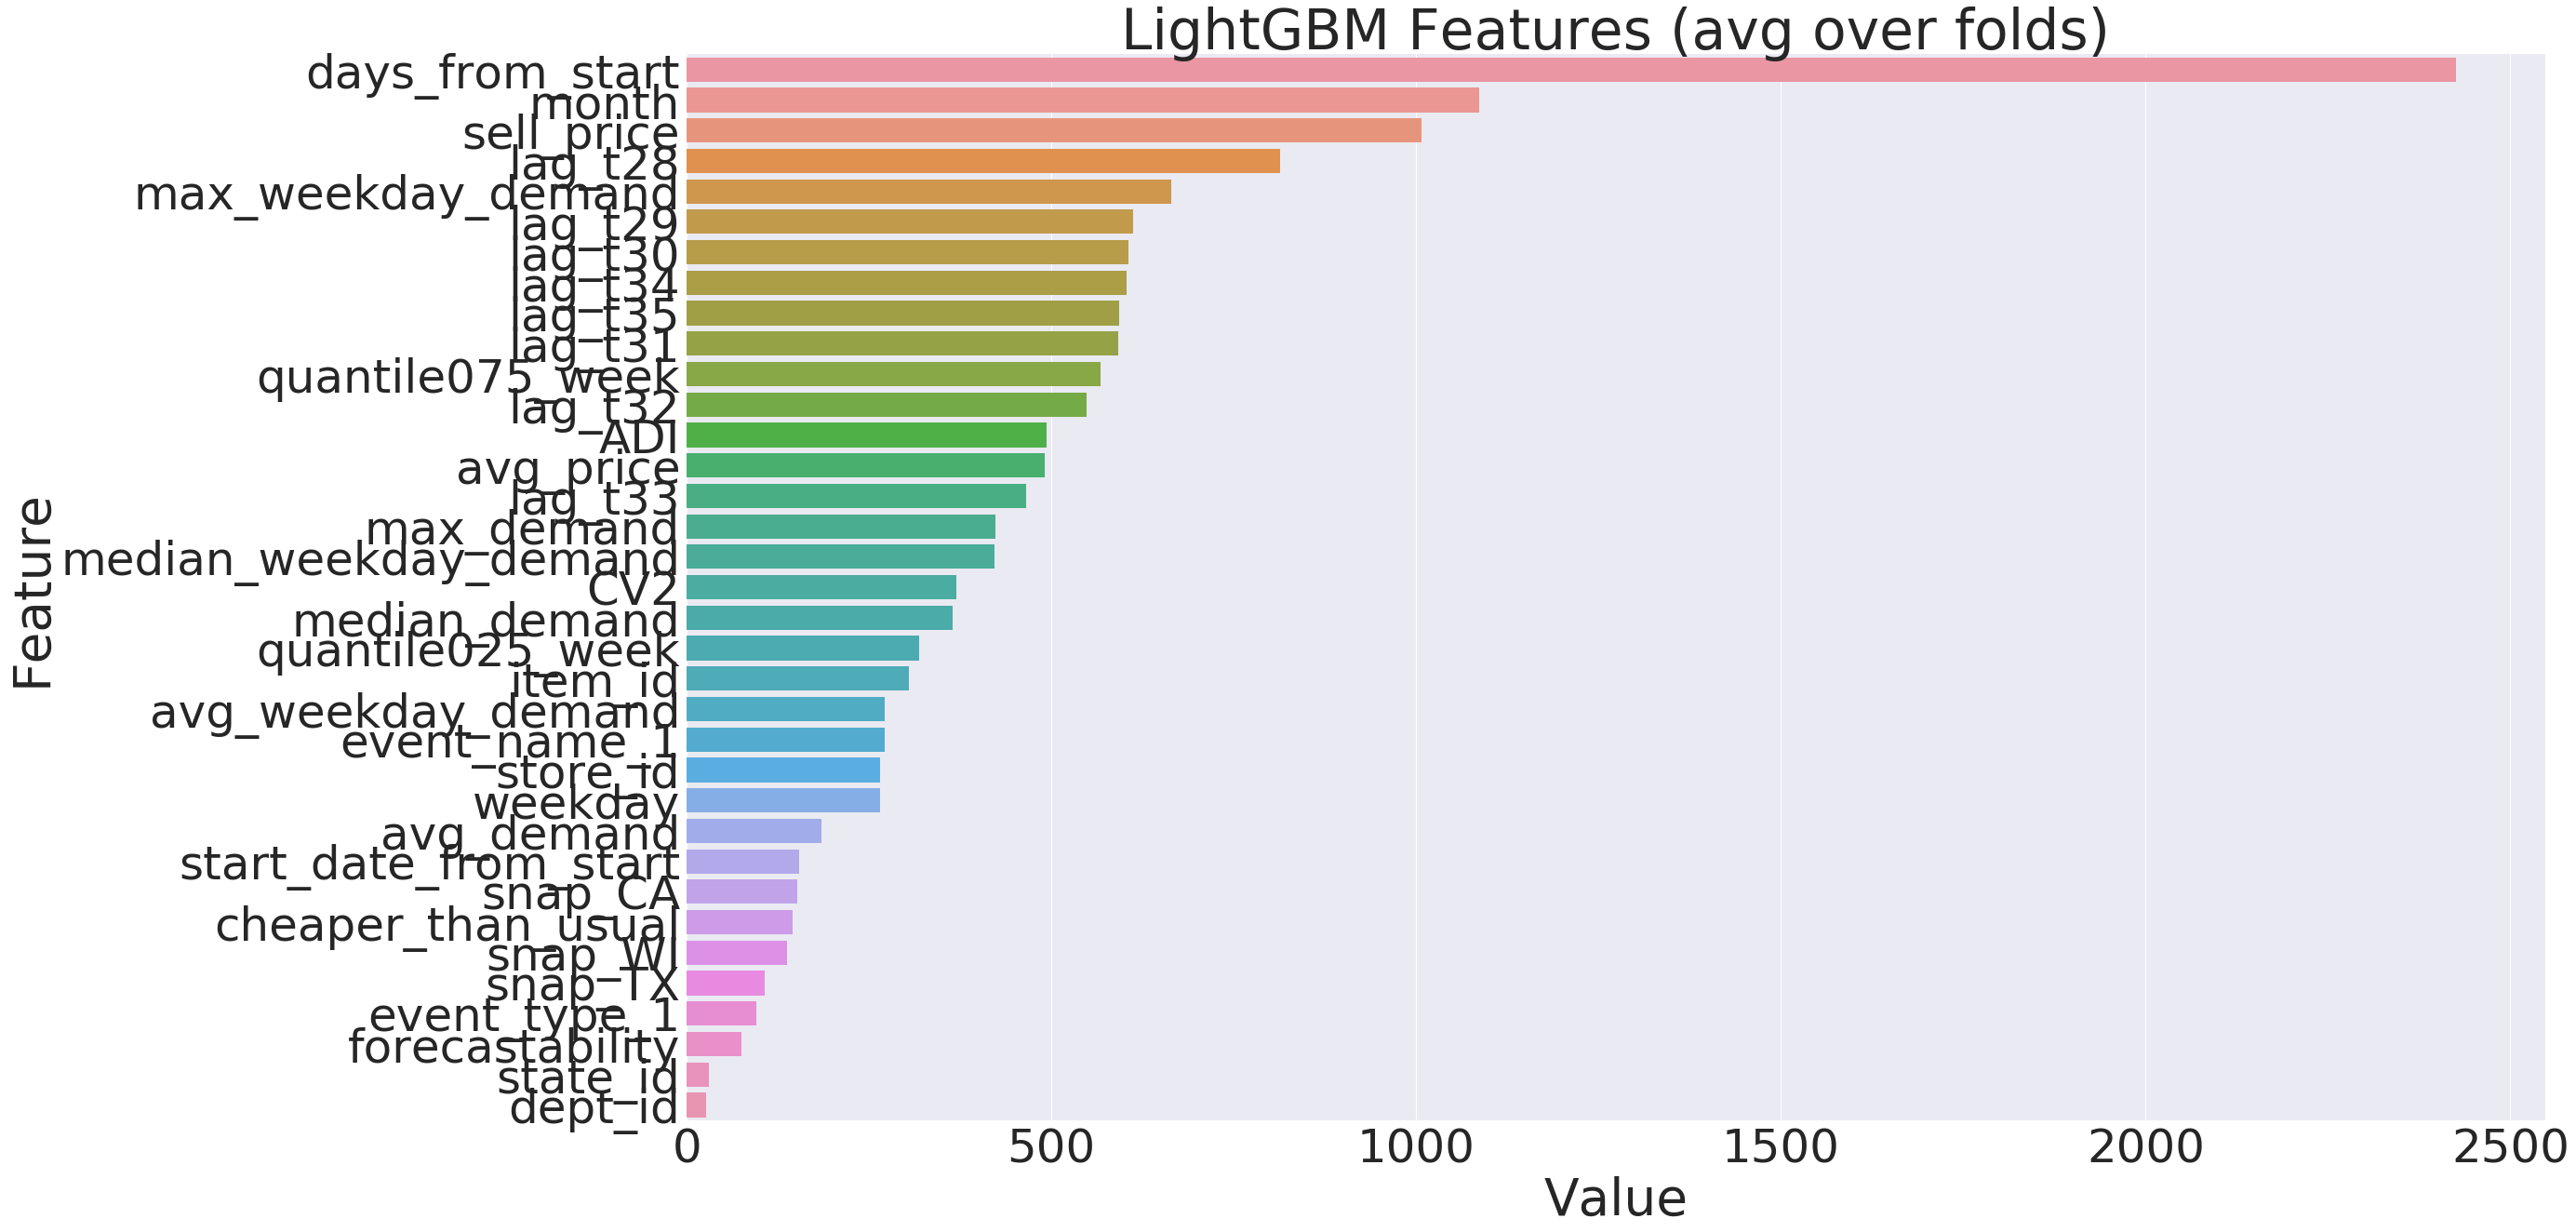

In [11]:
def plotImp(model, X , num = 20):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns})
    plt.figure(figsize=(40, 20))
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()
plotImp(model, X_train[features], 35)

Transform predictions to the right format

In [12]:
predictions = X_test[['id', 'date', 'items_sold']]
predictions = pd.pivot(predictions, index = 'id', columns = 'date', values = 'items_sold').reset_index()
predictions.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

evaluation_rows = [row for row in submission['id'] if 'evaluation' in row] 
evaluation = submission[submission['id'].isin(evaluation_rows)]

validation = submission[['id']].merge(predictions, on = 'id')
final = pd.concat([validation, evaluation])
final.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.752412,0.772645,0.555631,0.478091,0.571327,0.704163,0.631149,0.527942,0.772305,...,0.625251,0.987296,0.788859,0.640649,0.740619,0.633400,0.738433,0.778131,1.066735,0.827931
1,HOBBIES_1_002_CA_1_validation,0.407066,0.354122,0.351186,0.374659,0.357852,0.371808,0.350293,0.239218,0.187912,...,0.202500,0.235646,0.242902,0.172591,0.156358,0.220245,0.223996,0.236472,0.280238,0.264835
2,HOBBIES_1_003_CA_1_validation,0.301345,0.275903,0.274369,0.290122,0.354169,0.418177,0.352059,0.291905,0.289020,...,0.525638,0.665781,0.677502,0.577463,0.563689,0.604658,0.565080,0.608160,0.707666,0.609426
3,HOBBIES_1_004_CA_1_validation,1.877412,1.321727,1.400095,1.501586,1.472699,2.552179,2.715942,1.363386,1.208711,...,1.724459,2.299611,2.820901,1.696806,1.291936,1.162182,1.418431,1.598882,2.726303,3.316940
4,HOBBIES_1_005_CA_1_validation,0.928032,0.771856,0.901088,1.077295,1.105849,1.508413,1.772352,1.246374,1.107780,...,1.145866,1.538907,1.527176,0.960002,0.869601,0.959042,1.031527,1.224523,1.633094,1.751936


Save the submission, the features and the score to files.

In [13]:
final.to_csv('../04_submissions/lightGBM_no_fe.csv', index = False)

In [26]:
features = X_test.columns[~X_test.columns.isin(not_features)]
features = features.to_list()
features.append(str(val_score))

In [28]:
with open("../04_submissions/lgb_features_score.txt", "a") as outfile:
    outfile.write("\n".join(features))
